In [1]:
# If you are reading this notebook on a Binder, make sure to right-click the file name in
# the left-side file viewer and select `Open With > Notebook` to view this as a notebook

# <i class="fas fa-book fa-fw"></i> Ensemble Methods

Last time, we discussed the details of training and evaluating our decision tree model. In this chapter, we will discuss the powerful concept of **ensemble models**, or models composed of a group of smaller models. The idea is that maybe in combination, models that individually don't perform well individually, might perform better collectively. This follows an observation of "the wisdom of the crowd" where aggregate judgements often can outperform judgements of even an informed individually. One example of the wisdom-of-the-crowd comes from Francis Galton's observation of game at a fair in 1906 where 787 participants tried to guess the weight of a cow. This group of people included experts in cows such as farmers and butchers as well as regular folk who all guessed its weight. Surprisingly, the best guess for the weight was actually the *average guess* across all 787 participants; the average guess was 1196 lbs while the true weight was 1198 lbs. This average guess was much closer than any individual's guess, including the guesses of the experts.

Applying this idea to machine learning, we can hope to make a more accurate model by combining the guesses of individual models that might not be as effective on their own. There are many different approaches to how to combine models of various types into an ensemble, but they generally fall into three categories that we will explore in this chapter.

* **Stacking**
* **Bagging**
* **Boosting**

Note that these are broad classes that describe many types of models. In this chapter, we will primarily only explore one type of model for each category.

## Aside: Data Types

Before diving into the various types of ensemble models, we want to take a step back to have a discussion about the different types of data we will train our models on. This discussion has nothing to do with ensemble models directly, but is a more general concept when thinking of our machine learning pipeline.

Data that we receive can be varied in their formats and types. Very generally, there are two extremely common types of data that we see especially in most of the tabular data we have been working with (each with their own subtypes).

* **Numeric Data**  describes data representing numbers (quantitative)
* **Categorical Data** describes data representing distinct categories (qualitative)

### Numeric Data

Data describing numbers generally comes in one of two types.

* **Discrete** values that cannot be subdivided. For example, in our house price predicting example the features representing the number of bedrooms were integers (1, 2, 3, ...) that cannot be subdivided further.
* **Continuous** values can be subdivided. For example, the area of a house is a real number that can be infinitesimally subdivided (assuming precise enough measurements).

There is a tricky case of numeric values such as a price of the house. While it seems more like a continuous value, you can only break the units so far down to cents before not being able to go further. You generally have to consider if you would like to treat these variables as discrete or continuous. A general rule of thumb is if the discreteness comes from the unit of measurement (a bedroom has to be a whole number), then it should be discrete but if the discreteness comes from the quantity being measured (prices can only be broken down to cents), you can treat it as continuous. You will likely just need an extra step to round outputs to be the precision that is appropriate for the problem.

All of the ML models that we have described so far assume numeric inputs so very rarely is there preprocessing you need to do to make numeric data work. You may have to consider things like rounding as we described above based on the limitations of the numeric data precision, but generally that's not something you have to worry too much about.

### Categorical Data

Data describing categories also generally comes in one of two types.

* **Ordinal** data is categorical data that has a defined order. For example, a school rating of good/okay/bad has a clear ordering of which category can be considered greater than another.
* **Nominal** data is categorical data that does not have a defined order. For example, the type of school you attend being public/private/charter/homeschool does not have an ordering of which one of those school is greater than another (although everyone might have an opinion about which one may be best).

```{margin}
{{ref_sklearn_trees}}\. While this is true in theory, `sklearn` does not implement their tree like this so you actually do have to transform the values when using that library for all model types.
```

As we mentioned before, all of the ML models we have discussed so far (with the exception of Decision Trees<sup>{{ref_sklearn_trees}}</sup>) have assumed the inputs are numeric values. That means in order to train these models on data with categorical features, we have to do some preprocessing.

How might we go about transforming categorical variables into numeric ones? One natural idea is to use what we might call a *value encoding* to create a mapping from each category to a number. So for example of good/okay/bad, we could make the following mapping:

* Good = 1
* Okay = 0
* Bad = -1

This actually works fine in practice with ordinal data, if we choose our mappings to respect the ordering of the categories. However, this setup doesn't work at all with nominal values. Consider our example of a category for school type with the values public/private/charter/homeschool. We could come up with a value encoding such as the following.

* Public = 1
* Private = 2
* Charter = 3
* Homeschool = 4

By choosing this encoding for nominal values though has now introduced some problems in our data that we might not want. In particular:

* We have now defined an implicit ordering between the categories (Homeschool > Public) even though as nominal values, they are not supposed to have such an ordering.
* We have also added unintended relationships between how our model may consider the various feature values. Since they are just numbers to the model, the model would expect this feature to behave like any numeric feature would. That means you would expect mathematical statements such as Public (1) + Charter (3) = Homeschool (4) or Private (2) * Private (2) - Public (1) = Charter (3). These spurious numeric relationships are a byproduct of how we expect numbers to behave, so representing nominal values in this way will create completely unexpected relationships in our data.
  * This technically is also a critique of using value encodings for ordinal data, but because many models might only care about the relative ordering of feature values it generally doesn't cause problems.

To fix this, we will need a slightly more complicated encoding. One of the most common encoding types is a **one-hot encoding** that we briefly showed in a code example in the last chapter. A one-hot encoding turns a categorical feature into many categorical features, one for each value that feature took on, and indicates with a 1 if that example had that feature as a value. This is clearer with an example.

Consider a small school dataset with the following columns.

```{table} Raw School Dataset

| School  | Sq. Ft. | Rating |
|---------|---------|--------|
| Public  | 1000    | Good   |
| Private | 1500    | Bad    |
| Charter | 700     | Good   |
| Private | 1200    | Good   |
```

```{table} One-Hot Encoded Dataset

| School  - Public | School - Private | School - Charter | Sq. Ft. | Rating - Good | Rating - Bad |
|------------------|------------------|------------------|---------|---------------|--------------|
| 1                | 0                | 0                | 1000    | 1             | 0            |
| 0                | 1                | 0                | 1500    | 0             | 1            |
| 0                | 0                | 1                | 700     | 1             | 0            |
| 0                | 1                | 0                | 1200    | 1             | 0            |
```

## Stacking

**Stacking** involves taking the predictions of various model types and combining them into an overall model by weighting their responses. For a concrete example, we might train three different models on a training set such as:

* A Logistic Regression Model
* A Decision Tree Model
* A Neural Network

Each model will make a prediction $\hat{y}_j$ and these outputs are used as an input for another model type (usually Linear Regression for regression and Logistic Regression for classification) to synthesize an overall answer based on weighting their individual guesses.

```{figure} stacking.png
---
alt: A visual depiction of stacked models. The inputs go to three models (Decision Tree, Logistic Regression, Neural Networks) which go to the Stacked Model with various weights.
width:  80%
align: center
---
A Stacked model with 3 models in the ensemble each with weight $w_1, w_2, w_3$
```

We won't have much to say about this particular ensemble, as it is often much more of a heuristic of which models to use and learning the weights between them is simply training a model using their outputs as the overall-models inputs.

## Bagging - Random Forests

A **Random Forest** is a specific type of ensemble model that leverages the concept of **bagging**. Let's first discuss the idea of this specific model before defining what bagging means in general. A Random Forest is an ensemble model composed of $T$ Decision Trees. Each Decision Tree casts a "vote" for a particular label, and the ensemble combines all of the votes to make an overall prediction. For classification tasks, the votes are counted and the majority label is predicted. For regression the average label is predicted.

```{figure} random_forest.png
---
alt: A visual depiction of a random forest. Each tree casts a vote and the majority class is the overall ensemble's prediction
width: 100%
align: center
---
A Random Forest, where each tree gets to cast a vote for the predicted label.
```

A natural question is if we only have one training set, how can we learn a collection of $T$ trees. Clearly each tree would need to be different somehow. If they were all the exact same model and all made the exact same predictions, an ensemble of clones would make the exact same decisions as the individuals. So how can we create differences in the tree?

We accomplish this by creating sampled datasets by **bootstrapping** our original dataset. Bootstrapping is the process of randomly sampling from our dataset, with replacement, to make new versions of our dataset that are slightly different than the original. We make a bootstrapped version of our dataset for each of the $T$ trees we want to train, such that each dataset each tree trains on is now a random sample (with replacement) of our original dataset. A couple of key details about this sampling procedure.

```{margin}
{{ref_sampling}}\. Think of a simplified example of randomly pulling three marbles from a bag that contains one red marble, one white marble, and one blue marble. If you draw the three marbles, replacing them after you pull them out, it's entirely possible to draw the red one twice and the blue one once; thus leaving the white marble out of your set of 3 you drew.
```

* Each bootstrapped dataset will have $n$ examples like the original dataset. But because we sample with replacement, some examples from the original will be left out since we will not choose some by chance<sup>{{ref_sampling}}</sup>.
* We also select some number of features $m < D$ to randomly select that number of features for each bootstrapped sample. That means each tree is only trained on a subset of sized $m$ of our original features (Not shown in the figure below). We'll discuss this hyperparameter later.

```{figure} bootstrapping.png
---
alt: "Bootstrapping data for each tree by randomly selecting examples with replacement. Not shown: Also would randomly select features."
width: 60%
align: center
---
Bootstrapping data for each tree by randomly selecting examples with replacement. Not shown: Also would randomly select features.
```

Random Forests are a specific type of ensemble model known as a **Bagging Ensemble**. Bagging stands for "Bootstrapped aggregation" which comes from the fact that we are aggregating predictions over an ensemble of models trained on bootstrapped datasets.

So far, we have discussed our Random Forest is a collection of Decision Trees trained on random bootstraps of the original data. One important, but counter-intuitive, detail about these trees is we will also train them to grow *without any limit on how tall they can become*. This is precisely because we actually *want* each tree to overfit on the dataset it is trained on. It's weird that after a whole book of trying to prevent overfitting, we are actually going to encourage overfitting in this context.

The "why" of this comes from the property that models that overfit are generally high variance. Recall from our bias-variance tradeoff, that high variance means a model will change wildly even to minor changes in the data (thus likely to overfit). Also from that discussion, models that have high variance generally also have low bias. Remember that we defined low bias to mean that on average (over all models you could learn from all possible versions of your dataset), we will be learning the true function. This fact is exactly what we are taking advantage of in an ensemble like a Random Forest! By letting each tree overfit and averaging over all of them, our hope is that this "average model" will be close to the true function since the individual overfit trees have low bias.

### Random Forest Algorithm

```{prf:algorithm} Random Forest Training
:label: random_forest_training

**Input**: Training Dataset $D$. Hyperparameters: $T$ number of trees and $m$ number of features to select for each sample

**Output**: An ensemble of $T$ trees $\hat{F}$

1. For $i \in [1, ... T]$:
    1. $D' = bootstrap(D, m)$ to randomly sample (with replacement) $n$ rows and $m$ columns from $D$
    2. Train a tree $\hat{t}_i$ with no height limit on the data $D$ (only with $m$ features. The hope is these trees will overfit to the bootstrapped samples they are trained on.
        * Note that each tree needs to remember which $m$ features it trained on for prediction later on
2. Return ensemble of $T$ trees
```

```{prf:algorithm} Random Forest Prediction
:label: random_forest_prediction

**Input**: An ensemble of $T$ trained trees $\hat{F}$, and an input $x$ to make a prediction on

**Output**: A prediction $\hat{y} = \hat{F}(x)$ for input $x$

1. For $\hat{t}_i \in \hat{F}$:
    1. $x' = x$ with only the $m$ features $t_i$ trained on
    2. $\hat{y}_i = \hat{t}_i(x)$
2. Return aggregate of all $\hat{y}_i$
    * For regression: $\hat{y} = \frac{1}{T} \sum_{i=1}^T \hat{y}_i$
    * For classification: $\hat{y} = majority(\{\hat{y}_i\}_{i=1}^n)$
```

### Random Forest Properties

When thinking about Random Forests, the following bullet points of important properties this model has in general is useful to keep in mind. Like always, these are just generalizations and it doesn't mean you always should/shouldn't use these models in a specific context. But they are useful rules of thumb to know.

* Random Forests use overfitting to their advantage by averaging out over many overfit trees. Averaging is a great variance reduction technique in general that this ensemble employs.
`````{div} full-width

````{sidebar}
```{figure} kinect.png
---
alt: Screenshot of a paper showing how to highlight pose estimates from a 3D scan of body position
width: 100%
align: center
---
[Example paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/BodyPartRecognition.pdf) using Random Forests to estimate poses from a depth image
```
````
* Random Forests are versatile models that generally work pretty well in many contexts. Can use them in all sorts of settings such as regression, classification, clustering (not discussed), identifying important features.
* Random Forests are generally low maintenance models. That means you actually don't need to do much careful hyperparameter tuning (except for the number of features to sample $m$). Because we are averaging over all of these trees, we generally see improved generalization accuracy as we increase the number of trees $T$. More trees will take longer to train, but we don't really need to worry about overfitting by adding too many trees to our ensemble. While there are some hyperparameters to tune, they generally have a smaller effect on the model's performance. Because of this, Random Forests are often seen as a good "out of the box" model.
`````
* Random Forests are pretty efficient to train. Because we are sampling only $m$ features, training each tree is generally pretty fast (for reasonable $m << d$). In addition, the training of each tree is independent of the other. This means we can leverage concepts of *parallelization* to train trees on different CPUs to speed up our training time. If you wanted, you could buy a bunch of compute time from Amazon Web Services (AWS) and train one tree on each of the computers you rent to save you a lot of time!

### Random Forest Code

Training a Random Forest in scikit-learn is quite easy, and is similar to many of the models we have seen previously. The following code block shows how to train a Random Forest classifier on the income dataset we saw in the last chapter ([income.csv](./income.csv)).

In [2]:
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# Load in data, and separate features and label
data = pd.read_csv("income.csv")
label = "income"
features = data.columns[data.columns != label]

# Train test split
train_data, test_data, train_labels, test_labels = train_test_split(
    data[features], data[label], test_size=0.2)

# Transform categorical features. Note that we use the same transformation
# on both train and test
encoder = OneHotEncoder(handle_unknown='ignore')\
    .fit(train_data)
train_data = encoder.transform(train_data)
test_data = encoder.transform(test_data)

# Train model
model = RandomForestClassifier(n_estimators=200)
model.fit(train_data, train_labels)

# Make predictions
train_predictions = model.predict(train_data)
test_predictions = model.predict(test_data)

print("Train Accuracy:", accuracy_score(train_labels, train_predictions))
print("Test  Accuracy:", accuracy_score(test_labels, test_predictions))

Train Accuracy: 1.0
Test  Accuracy: 0.8593582066635959


In [3]:
# import matplotlib.pyplot as plt
#
# MAX_TREES = 300
#
# num_trees = list(range(1, MAX_TREES + 1, 5))
# train_accs = []
# test_accs = []
#
# model = RandomForestClassifier(warm_start=True)  # Use last iteration to start next
#
# for i in num_trees:
#     model.set_params(n_estimators=i)
#
#     model.fit(train_data, train_labels)
#
#     train_predictions = model.predict(train_data)
#     test_predictions = model.predict(test_data)
#
#     train_accs.append(accuracy_score(train_labels, train_predictions))
#     test_accs.append(accuracy_score(test_labels, test_predictions))
#
# # Plot results
# fig, ax = plt.subplots(1)
# ax.plot(num_trees, train_accs, label="Train")
# ax.plot(num_trees, test_accs, label="Test")
#
# ax.set_title("Improved Performance when Adding Trees to Random Forest")
# ax.set_xlabel("Num Trees")
# ax.set_ylabel("Accuracy (clipped)")
# ax.legend()

### Practicalities

We conclude this section with a few practical details about using Random Forests.

#### Number of features $m$

While adding more trees will generally improve the Random Forest model, that doesn't mean you don't have to do any hyperparameter tuning. Recall that in our bootstrapping step, we randomly select $n$ rows and $m$ features, where $n$ is the number of training points in the original dataset and $m$ is a hyperparameter. Randomly selecting features is important for the overall ensemble being better since it de-correlates all of the trees in the ensemble. In general, you have to tune this value for $m$ by comparing the performance of various models with different settings on $m$ with a validation set or cross validation. The authors of the original Random Forest paper suggest $m = \sqrt{D}$ features for each sample in regression tasks and $m = \lfloor D/3 \rfloor$ for classification tasks. It's unclear how effective those actually are, but they are starting points that you can then tune from.

#### Out of Bag (OOB) Error

One useful feature of Random Forests is that you can actually get an estimate of future performance of the ensemble without a test set and only using the training set! While that seems surprising, we are able to do this by relying on the fact that not every tree in the ensemble saw every example from the training set. Because each tree was trained on a bootstrapped sample of the training sets, some of the examples will be left out from each trees bootstrapped dataset. If we want to estimate future error, we can do so by asking each tree to make predictions on the training points it *didn't* train on.

This concept is called the **Out of Bag Error** (OOB Error). To calculate it we have the ensemble make a prediction on every training point, but only allow the trees that didn't train on that training point to have a vote in the decision. Then we just collect all of these ensemble predictions over our training set and compute whichever quality metric we are using on the predictions and true labels.

## Boosting - AdaBoost

In this last section of the chapter, we will introduce another type of ensemble model that is also a collection of trees, but the details of how it works are quite different. We will explore a particular learning algorithm called **AdaBoost** that is an example of our final type of ensemble, a **boosted ensemble**. Before defining what these terms are, let's explore a bit of the history that led to the model's inception.

Many machine learning researchers aer interested in the theoretical limits of ML models: what they can or can't learn, what guarantees we can make about a model's performance, and many other important questions. One example problem was asking if an ensemble could be constructed from ineffective models to make a better ensemble. A **weak learner** is a model that does only slightly better than random guessing at a task. Kearns and Valient (1988, 1989) asked if a set of weak learners in an ensemble could be created to make a strong learner. In 1990, Schapire found that this could be done with a model he called the AdaBoost model.

**AdaBoost** is an ensemble of decision trees much like Random Forests, that has three notable differences that impact how we train it. We'll present these differences at a high-level before diving into details with an example.

1. Instead of using tall decision trees that overfit to the data, we will limit the models in the ensemble to *decision stumps* (one branch).
2. Instead of doing a majority vote over the models in the ensemble, each model will be assigned a weight and we take a *weighted majority vote*. For example, if we are in a binary classification setting where $y \in \{+1, -1\}, we will make predictions as follows where $\hat{f}_t(x)$ is the prediction of decision stump $t$ and $\hat{w}_t$ is that models weight for the majority vote.

$$\hat{y} = \hat{F}(x) = sign\left( \sum_{t=1}^T \hat{w}_t \hat{f}_t(x) \right)$$
3. Instead of bootstrapping datasets for each model in the ensemble, we will use the whole dataset to train each decision stump. To add variation between stumps, we will add a notion of *datapoint weights* $\alpha_i$ and find decision stumps that minimize a notion of *weighted classification error*.


### AdaBoost Predictions

Before discussing all of the details behind these differences, let's see an example AdaBoost model and how it makes predictions. In the figure below, we have an AdaBoost model with four decision stumps and which each model predicts on some example point $x$.

```{figure} adaboost.png
---
alt: Four decision stumps in an AdaBoost model with various model weights (explained below)
width: 100%
align: center
---
Example AdaBoost ensemble
```

To find the ensemble's prediction for the input $x$, we have to first get the prediction from each stump in the ensemble and then combine their predictions with their weights to get a weighted majority vote.

$$\hat{y} &= \hat{F}(x)\\
 &= sign\left( \sum_{t=1}^T \hat{w}_t \hat{f}_t(x) \right)\\
 &= sign\left(2 \cdot 1  + (-1) \cdot (-1) + 1.5 \cdot (-1) + 0 \cdot (-1)\right)\\
 &= sign(1.5)\\
 &= +1 $$

### AdaBoost Training

So as we mentioned before, our training procedure for AdaBoost is going to be quite different than it was for Random Forests. In AdaBoost, we will be training each model *in succession*, where we will use the errors the previous model made to influence how the next model is trained. This process is a specific example of the general concept of **boosting** in ensembles, where future models are trained based on the results of previous models.

To do this, we will keep track of two sets of weights for AdaBoost:

* Model weights $\hat{w}_t$ that we will use to weight the predictions from each model. These are the weights discussed in the last section. The intuition for how we will compute these weights is that a more accurate model in our ensemble should have a higher weight in the ensemble.
* Dataset weights $\alpha_i$ that will influence how we train each model. The intuition is that we will want to put more emphasis on examples with more weight, and put more weight on examples that are often misclassified.

So at a high-level, our AdaBoost training algorithm will have the following steps. We will repeat this algorithm at the end of the section with all of the details filled in.

```{prf:algorithm} AdaBoost Training
:label: adaboost_training_1

**Input**: Training Dataset $X \in \mathbb{R}^{n\times d}, y \in \{0, 1\}$. Hyperparameters: Number of trees $T$

**Output**: An AdaBoost ensemble of $T$ trees $\hat{F}$

1. For $i \in [1, ... T]$:
    1. Learn $\hat{f}_t(x) based on current dataset weights $\alpha_{i,t}$
    2. Compute model weight $\hat{w}_t$ for learned model
    3. Update dataset weights $\alpha{i, t+1}$
2. Return AdaBoost ensemble with $T$ trees and model weights $\{\hat{w}_t\}_{t=1}^T$
```

In the following sub-sections, we will explain each of these bullet points in detail.

#### Learning from Weighted Data

A key part of the AdaBoost algorithm is associated a weight to each example in our training set. At a high level, we will be updating weights to increase the weights of examples we get wrong and decreasing the weights for examples we get right. But how do we utilize those weights?

```{table} Example Dataset Weights for a small cancer dataset
:name: example_weights

| TumorSize | IsSmoker | Malignant (y) | Weight |
|-----------|----------|---------------|--------|
| Small     | No       | No            | 0.5    |
| Small     | Yes      | Yes           | 1.2    |
| Large     | No       | No            | 0.3    |
| Large     | Yes      | Yes           | 0.5    |
| Small     | Yes      | No            | 3.3    |
```

Instead of finding a Decision Stump to minimize classification error, we we will find the Decision Stump that minimizes a **weighted classification error**. The intuition is we care about the fraction of the training dataset weight that we label incorrectly, and want to minimize this weighted error. Another intuition is if an example has weight $\alpha_{i, t} = 2$, then making a mistake on that example is twice as bad as making a mistake on an example with weight 1.

$$WeightedError(f_t) = \frac{\sum_{i=1}^n \alpha_{i,t} \cdot \indicator{\hat{f_t}(x) \neq y_i}}{\sum_{i=1}^n \alpha_{i,t}}$$

So our decision stump learning algorithm is mostly the same, but now we try to find the stump with the lowest weighted error. That also means when it comes to deciding the prediction for a leaf node, we will predict the class with the largest weight at that leaf instead of the highest number of examples. Consider two possible splits for a decision stump on {numref}`example_weights`.

```{figure} weighted_stumps.png
---
alt: Two decision stumps, one split on TumorSize and the other IsSmoker, and their predictions
width: 100%
align: center
---
Two possible Decision Stumps based on weighted error. Note that the right stump predicts No for both branches because each leaf node has more weight on the No class.
```

To compute the weighted error for each stump, we compute the fraction of the total weight that gets misclassified.

* For the first stump split on TumorSize, the weighted error is
  $$\frac{0.3 + 1.2}{5.8} \approx 0.26$$
* For the second stump split on IsSmoker, the weighted error is
  $$\frac{1.7 + 0}{5.8} \approx 0.29$$

Since the first stump has lower weighted error, that's the one we would choose with these weights.

A similar procedure for finding the best split of a numeric feature can also be used, where we decide the threshold that has the lowest weighted error.

#### Model Weights $\hat{w}_t$

Now that we have a procedure to train one of the Decision Stumps in our ensemble, we can now compute the next weights outlined in {prf:ref}`adaboost_training_1`: $\hat{w}_t$.

Our intuition for these model weights was to assign more weight to models that are more accurate, and less weight to models that are less accurate. Without proof, we will just show that the following formula works well for model weights.

$$\hat{w}_t = \frac{1}{2} \ln\left( \frac{1 - WeightedError(\hat{f}_t)}{WeightedError(\hat{f}_t)}\right)$$

If you plug in the weighted error from our last example (0.26), the model weight for that model would be

$$\hat{w}_t = \frac{1}{2} \ln\left( \frac{1 - WeightedError(\hat{f}_t)}{WeightedError(\hat{f}_t)}\right) = \frac{1}{2}\ln\left(\frac{1 - 0.26}{0.26} \right) \approx 0.52$$

In the following plot, we show that this formula has the desired property of assigning more weight to more accurate models and less weight to less accurate models.

/tmp/ipykernel_143/1356952037.py:5: RuntimeWarning: divide by zero encountered in log
  model_weights = np.log((1 - errors) / errors) / 2


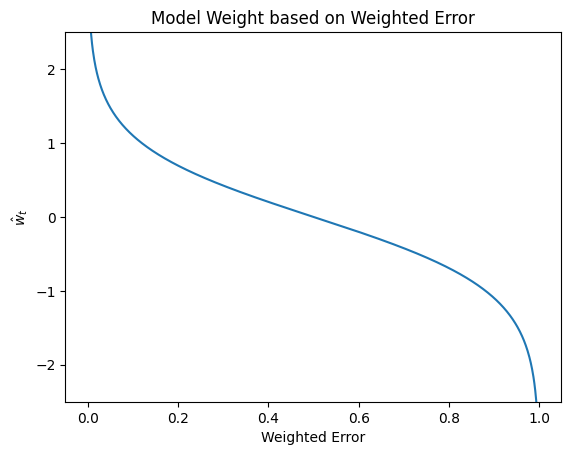

In [4]:
import matplotlib.pyplot as plt
import numpy as np

errors = np.linspace(0.0001, 1, 1000)
model_weights = np.log((1 - errors) / errors) / 2

plt.plot(errors, model_weights)
plt.title("Model Weight based on Weighted Error")
plt.xlabel("Weighted Error")
plt.ylabel("$\hat{w}_t$")
plt.ylim((-2.5, 2.5));

Note that the output of the model weights are unbounded and can range from $(-\infty, \infty)$. One peculiar fact is that the model weights can in fact be negative. A negative model weight for a binary classification setting actually means we are *reversing* the predictions of that model. Consider an example of a model with $WeightedError = 0.99$ makes mistakes on the vast majority of the weight examples. While that classifier sounds really bad, it's actually a really good classifier if you just swap it's predictions. If you just do the opposite of what it says, you will only have $WeightedError = 0.01$!

#### Computing Dataset Weights $\alpha_{i, t+1}

For the last step of the AdaBoost training algorithm, we need to update the dataset weights for the next iteration so that the next iteration pays more attention to different examples. Our goal is that examples that we made mistakes on should get higher weight while examples that were predicted correctly should have lower weight. We will use the following update formula.

$$\alpha_{i, t+1} = \begin{cases}
        \alpha_{i, t}e^{-\hat{w}_t} & \text{if } \hat{f}_t(x) = y_i\\
        \alpha_{i, t}e^{\hat{w}_t} & \text{if } \hat{f}_t(x) \neq y_i\\
  \end{cases}$$

This multiplicative weight update increases the weights for examples where the there was a misclassification and decreases the weights for examples where the classification was correct.

As a implementation note, we often normalize the dataset weights after updating them so they are all on the same scale. This isn't a problem since weighted classification error is already a fraction of the total weight. But by having them all in the same scale, we avoid some numeric stability issues.

$$\alpha_{i, t+1} \gets \frac{\alpha_{i, t+1}}{\sum_{j=1}^n \alpha_{j, t+1}}$$

#### Putting it all Together

```{prf:algorithm} AdaBoost Training (First Glance)
:label: adaboost_training_2

**Input**: Training Dataset $X \in \mathbb{R}^{n\times d}, y \in \{0, 1\}$. Hyperparameters: Number of trees $T$

**Output**: An AdaBoost ensemble of $T$ trees $\hat{F}$

1. Initialize dataset weights $\alpha_{i, 1} = 1/n$
2. For $i \in [1, ... T]$:
    1. Learn $\hat{f}_t(x) based on current dataset weights $\alpha_{i,t}$ to find a stump that minimizes

        $WeightedError(f_t) = \frac{\sum_{i=1}^n \alpha_{i,t} \cdot \indicator{\hat{f_t}(x) \neq y_i}}{\sum_{i=1}^n \alpha_{i,t}}$
    2. Compute model weight $\hat{w}_t$ for learned model

        $\hat{w}_t = \frac{1}{2} \ln\left( \frac{1 - WeightedError(\hat{f}_t)}{WeightedError(\hat{f}_t)}\right)$
    3. Update dataset weights $\alpha{i, t+1}$

        $\alpha_{i, t+1} = \begin{cases}
                \alpha_{i, t}e^{-\hat{w}_t} & \text{if } \hat{f}_t(x) = y_i\\
                \alpha_{i, t}e^{\hat{w}_t} & \text{if } \hat{f}_t(x) \neq y_i\\
          \end{cases}$
    4. Normalize dataset weights

       $\alpha_{i, t+1} \gets \frac{\alpha_{i, t+1}}{\sum_{j=1}^n \alpha_{j, t+1}}$


2. Return AdaBoost ensemble with $T$ trees and model weights $\{\hat{w}_t\}_{t=1}^T$
```

### AdaBoost code

Training an AdaBoost model with a library like `scikit-learn` is very easy just like with Random Forests. Here is a similar code example that shows how to use the `scikit-learn` library implementation of AdaBoost.

In [5]:
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import AdaBoostClassifier

# Load in data, and separate features and label
data = pd.read_csv("income.csv")
label = "income"
features = data.columns[data.columns != label]

# Train test split
train_data, test_data, train_labels, test_labels = train_test_split(
    data[features], data[label], test_size=0.2)

# Transform categorical features. Note that we use the same transformation
# on both train and test
encoder = OneHotEncoder(handle_unknown='ignore')\
    .fit(train_data)
train_data = encoder.transform(train_data)
test_data = encoder.transform(test_data)

# Train model
model = AdaBoostClassifier(n_estimators=300)
model.fit(train_data, train_labels)

# Make predictions
train_predictions = model.predict(train_data)
test_predictions = model.predict(test_data)

print("Train Accuracy:", accuracy_score(train_labels, train_predictions))
print("Test  Accuracy:", accuracy_score(test_labels, test_predictions))

Train Accuracy: 0.8758829852579852
Test  Accuracy: 0.8708736373407032


### AdaBoost Walkthrough

To understand this process more concretely, let's walk through the steps to train an AdaBoost model. The exact code for this section is not as important to understand, but it is important to understand the computations we are doing and their results.

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from myst_nb import glue
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier



X_LIM = (0, 10)
Y_LIM = (0, 9)

def animl_plot(data, *, dataset_weights=None, model=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1)

    pos_data = data[data["label"] == "positive"]
    neg_data = data[data["label"] == "negative"]

    if dataset_weights is None:
      pos_s = 200
      neg_s = 200
    else:
      pos_weights = dataset_weights[data["label"] == "positive"]
      neg_weights = dataset_weights[data["label"] == "negative"]

      # Hard coding some numbers to scale weights to meaningful sizes
      effective_weight_max = 0.1
      start_s = 50
      effective_max_s = 200
      pos_s = start_s + effective_max_s * pos_weights / effective_weight_max
      neg_s = start_s + effective_max_s * neg_weights / effective_weight_max


    ax.scatter(x=pos_data["feature1"], y=pos_data["feature2"],
                c="blue", marker="+", s=pos_s)
    ax.scatter(x=neg_data["feature1"], y=neg_data["feature2"],
                c="orange", marker="x", s=neg_s) #weight_scale * neg_weights)

    if model:
        DecisionBoundaryDisplay.from_estimator(
            model, data[["feature1", "feature2"]], response_method="predict",
            xlabel="feature1", ylabel="feature2",
            alpha=0.1, colors=["orange", "black", "blue", "black"],
            ax=ax)
    ax.set_xlabel("feature1")
    ax.set_ylabel("feature2")
    ax.set_xlim(X_LIM)
    ax.set_ylim(Y_LIM)


class AnimlAdaBoost:
    def __init__(self, models=None, model_weights=None):
        self.models = models if models else []
        self.model_weights = model_weights if model_weights else []
        self.is_fitted_ = True
        self.classes_ = ["negative", "positive"]
        self.limit = None

    def add_tree(self, tree, model_weight):
        if self.limit is not None:
            raise ValueError("Unable to add trees if limit is set. Set to None first")
        self.models.append(tree)
        self.model_weights.append(model_weight)

    def fit(self, X, y):
        raise NotImplemented()

    def limit_to(self, i):
        self.limit = i

    def predict(self, data):
        # Assumes binary positive/negative predictions
        total_preds = np.zeros(len(data))

        limit = len(self.models) if self.limit is None else self.limit

        for i in range(limit):
            model = self.models[i]
            weight = self.model_weights[i]
            preds = model.predict(data)
            preds = np.array([+1 if pred == "positive" else -1 for pred in preds])
            total_preds = total_preds + weight * preds

        result = np.array(["positive" if total_pred > 0 else "negative" for total_pred in total_preds])
        return result

We start by loading in our [synthetic dataset](./synthetic.csv) as an example and plot out the points.

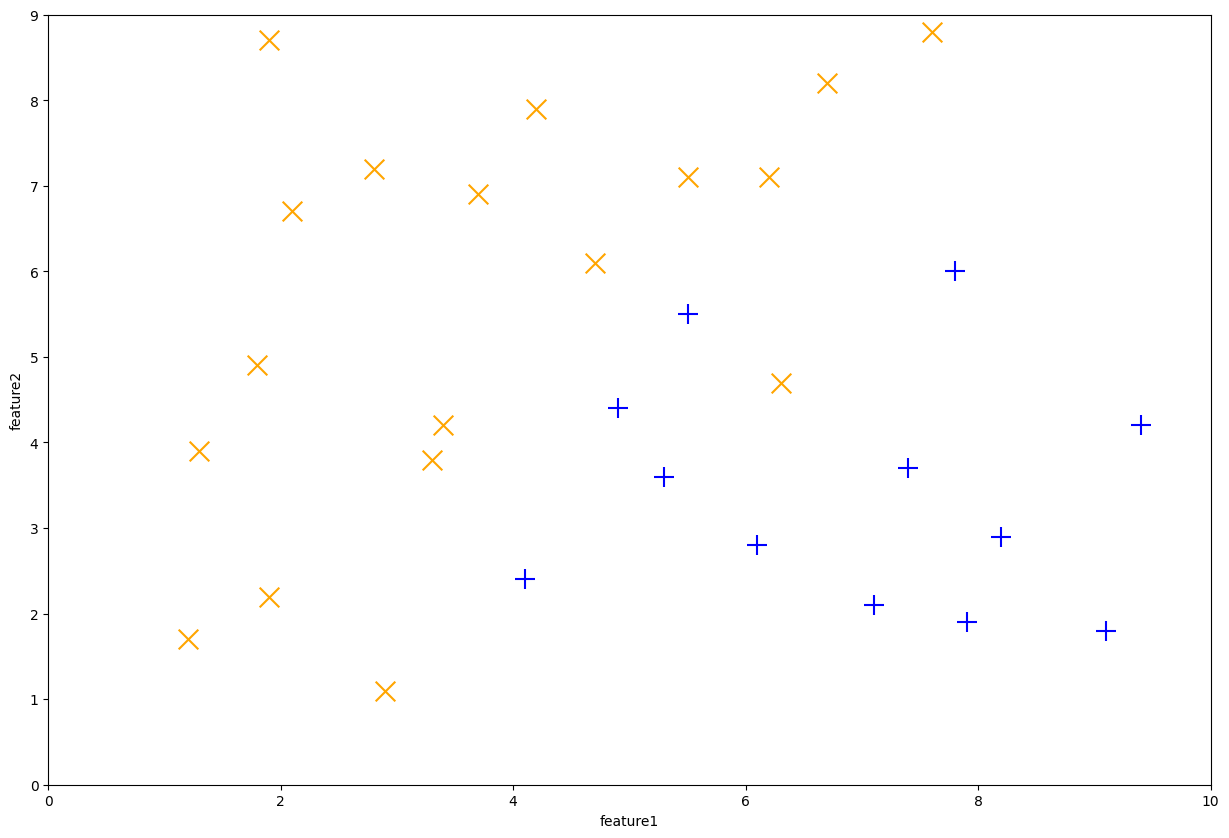

In [7]:
import pandas as pd

# Read in data
data = pd.read_csv("./synthetic.csv")
features = ["feature1", "feature2"]
label = "label"

_, ax = plt.subplots(1, figsize=(15, 10))
animl_plot(data, ax=ax)

We then training a decision stump that minimizes the weighted classification error. To start, the `dataset_weight` ($\alpha_{i, 1}$) start off as equal weight on each data point. Note that the size of each data point corresponds to its weight, in this plot they are all the same. We can see the decision boundary for this stump. After training this decision stump, we calculate the model's weighted error to compute the model weight and updated dataset weights.

Initial Dataset Weights:
[0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]

Weighted Error: 0.2
Model Weight  : 0.6931471805599453

New Dataset Weights:
[0.02083333 0.02083333 0.02083333 0.02083333 0.08333333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.08333333 0.08333333
 0.02083333 0.08333333 0.08333333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.08333333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333]


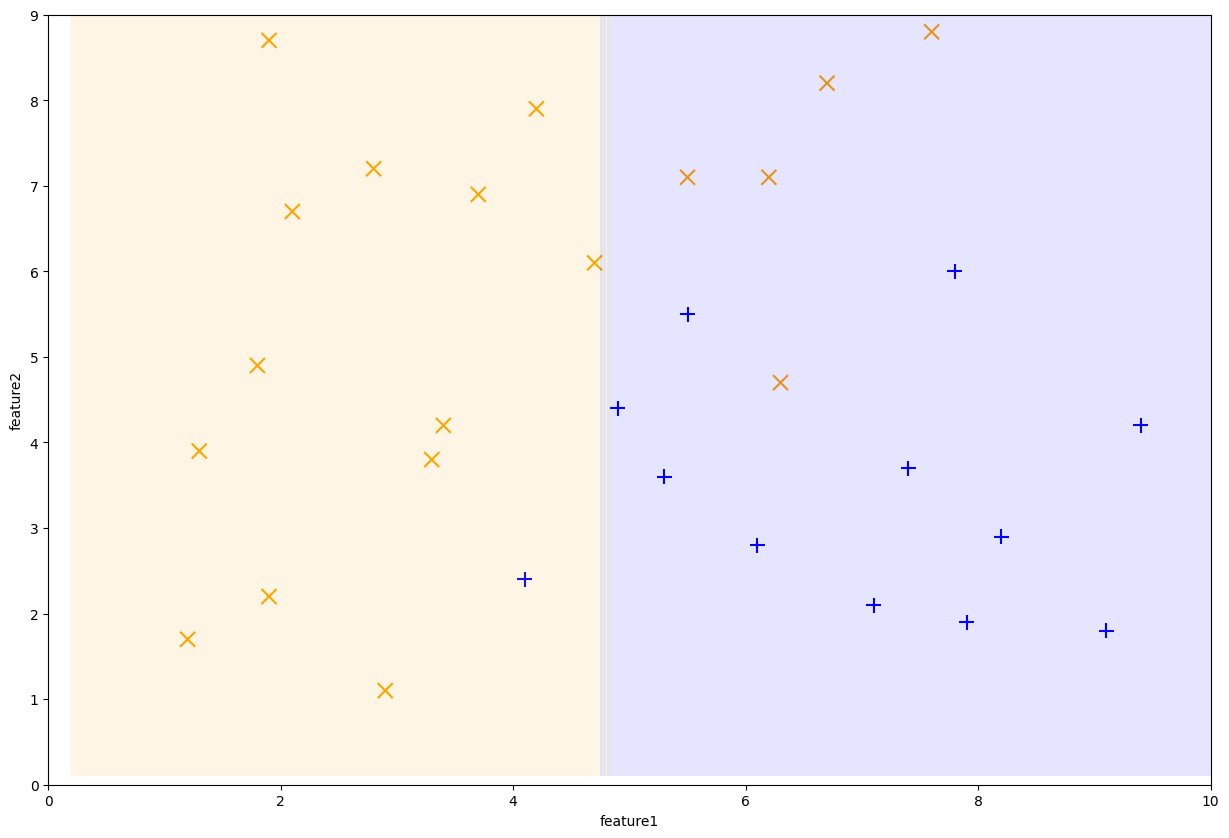

In [8]:
import numpy as np

def animl_train_stump(data, labels, dataset_weights, verbose=False):
    original_dataset_weights = dataset_weights  # Save for later for printing

    # Train the weak classifier on the data with the current weights
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(data, labels, sample_weight=dataset_weights)
    predictions = stump.predict(data)

    # Calculate the weighted error
    errors = predictions != labels
    weighted_error = np.dot(dataset_weights, errors) / np.sum(dataset_weights)

    # Calculate the model weight
    model_weight = np.log((1 - weighted_error) / weighted_error) / 2

    # Update dataset weights
    multiplier = 2 * errors - 1  # 1 for error, -1 for correct
    dataset_weights =  dataset_weights * np.exp(model_weight * multiplier)

    # Normalize dataset weights
    dataset_weights = dataset_weights / np.sum(dataset_weights)

    if verbose:
      print("Initial Dataset Weights:")
      print(np.array(original_dataset_weights))
      print()
      print("Weighted Error:", weighted_error)
      print("Model Weight  :", model_weight)
      print()
      print("New Dataset Weights:")
      print(np.array(dataset_weights))

    return stump, model_weight, dataset_weights

# Initialize the dataset weights to be uniform
dataset_weights = np.array([1/len(data) for _ in range(len(data))])

# Train a decision stump
tree1, model_weight1, new_dataset_weights = animl_train_stump(data[features], data[label], dataset_weights, verbose=True)

# Plot with original weights that were trained on
fig, ax = plt.subplots(1, figsize=(15, 10))
animl_plot(data, dataset_weights=dataset_weights, model=tree1, ax=ax)

After this step, the dataset weights now look like the following. Note that the first stump made 6 mistakes, so those 6 points are now larger while the remaining ones are smaller.

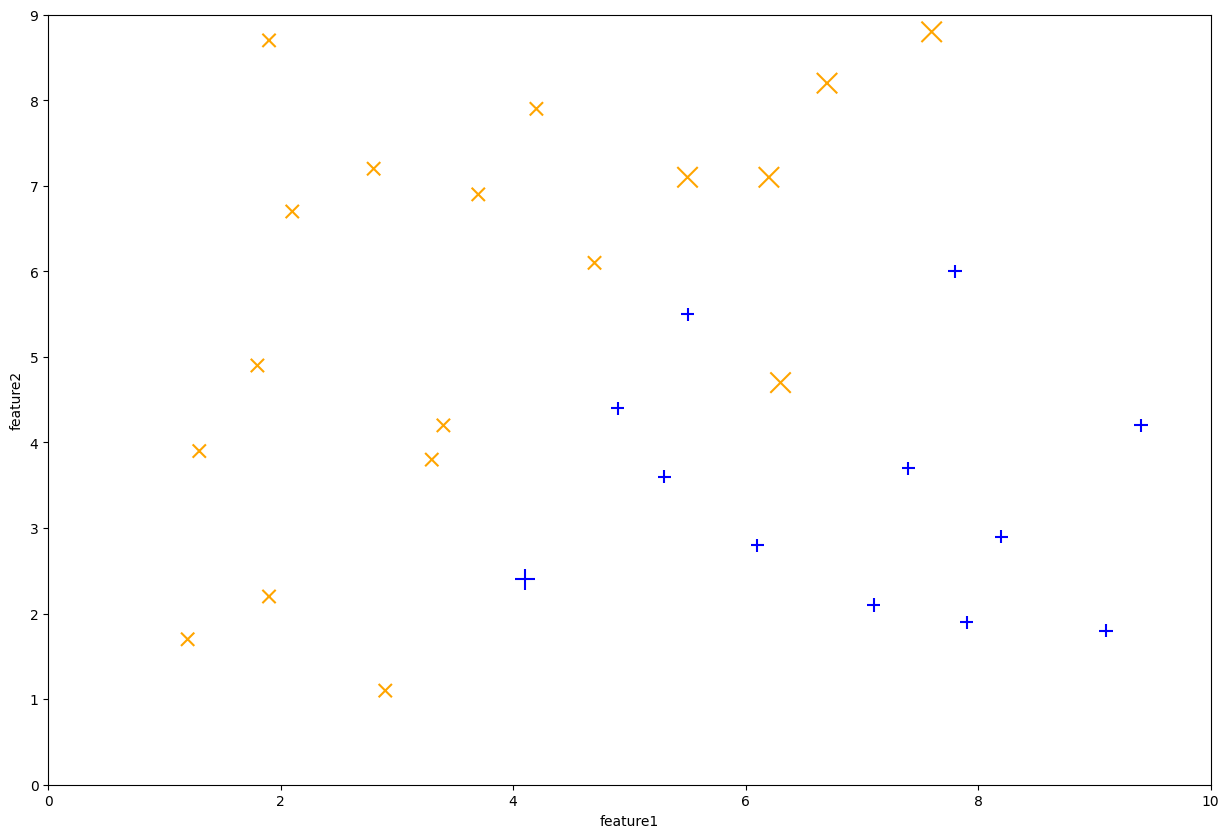

In [9]:
dataset_weights = new_dataset_weights
_, ax = plt.subplots(1, figsize=(15, 10))
animl_plot(data, dataset_weights=dataset_weights, ax=ax )

One the next iteration when we learn the next stump, we now use the new dataset weights and find the next stump that has the lowest weighted classification error. Again, we follow the steps to train the stump, calculate its weighted error, use that to calculate the model weight, and then update the dataset weights for the next iteration.

Initial Dataset Weights:
[0.02083333 0.02083333 0.02083333 0.02083333 0.08333333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.08333333 0.08333333
 0.02083333 0.08333333 0.08333333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.08333333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333]

Weighted Error: 0.1458333333333333
Model Weight  : 0.8838309588244975

New Dataset Weights:
[0.01219512 0.01219512 0.01219512 0.01219512 0.04878049 0.01219512
 0.01219512 0.01219512 0.01219512 0.01219512 0.04878049 0.04878049
 0.07142857 0.04878049 0.04878049 0.01219512 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.01219512 0.04878049 0.01219512
 0.01219512 0.01219512 0.01219512 0.01219512 0.07142857 0.01219512]


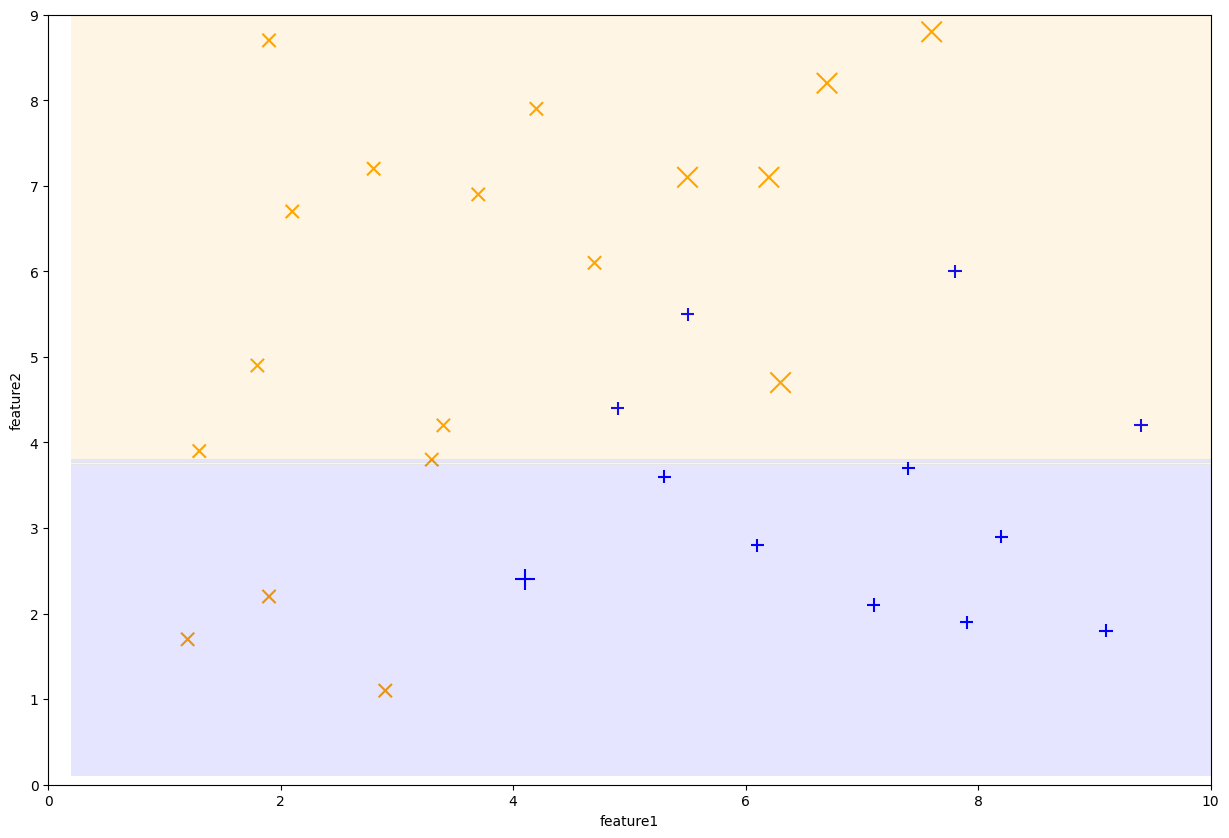

In [10]:
# Train a decision stump
tree2, model_weight2, new_dataset_weights = animl_train_stump(data[features], data[label], dataset_weights, verbose=True)

# Plot with original weights that were trained on
fig, ax = plt.subplots(1, figsize=(15, 10))
animl_plot(data, dataset_weights=dataset_weights, model=tree2, ax=ax)

We can continue this process for another stump after updating all of our weights again. The following plot shows the decision boundary of the new stump and the dataset weights it trained on.

Initial Dataset Weights:
[0.01219512 0.01219512 0.01219512 0.01219512 0.04878049 0.01219512
 0.01219512 0.01219512 0.01219512 0.01219512 0.04878049 0.04878049
 0.07142857 0.04878049 0.04878049 0.01219512 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.01219512 0.04878049 0.01219512
 0.01219512 0.01219512 0.01219512 0.01219512 0.07142857 0.01219512]

Weighted Error: 0.2682926829268292
Model Weight  : 0.5016510544318926

New Dataset Weights:
[0.00833333 0.00833333 0.00833333 0.00833333 0.09090909 0.00833333
 0.00833333 0.00833333 0.00833333 0.02272727 0.03333333 0.09090909
 0.04880952 0.09090909 0.09090909 0.00833333 0.04880952 0.04880952
 0.04880952 0.04880952 0.04880952 0.02272727 0.09090909 0.00833333
 0.00833333 0.00833333 0.00833333 0.00833333 0.04880952 0.00833333]


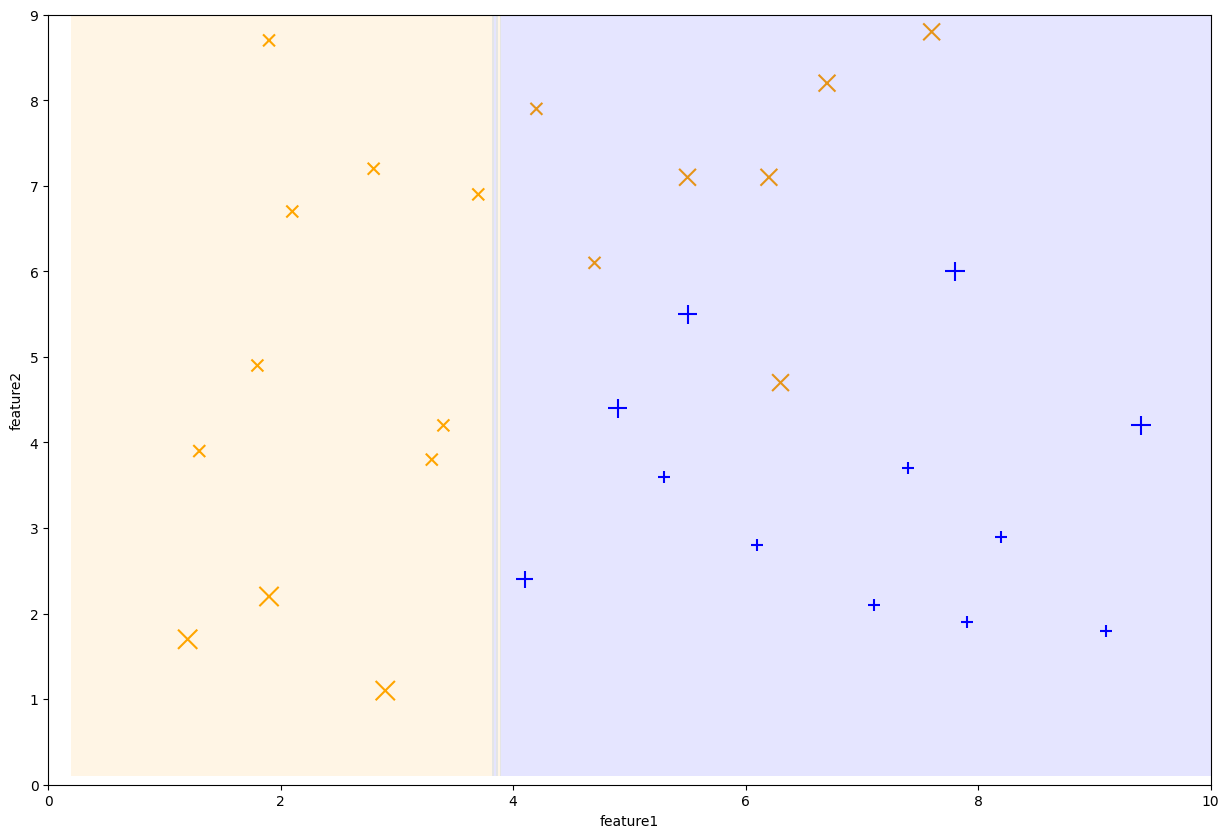

In [11]:
dataset_weights = new_dataset_weights
# Train a decision stump
tree3, model_weight3, new_dataset_weights = animl_train_stump(data[features], data[label], dataset_weights, verbose=True)

# Plot with original weights that were trained on
fig, ax = plt.subplots(1, figsize=(15, 10))
animl_plot(data, dataset_weights=dataset_weights, model=tree3, ax=ax)

At this point, our AdaBoost ensemble has two trees in it. We can compute a similar decision boundary, but for the whole ensemble. Recall that the predictions for AdaBoost follow the formula

$$\hat{y} = \hat{F}(x) = sign\left(\sum_{t=1}^T \hat{w}_t \hat{f}_t(x)\right)$$

In [12]:
import sympy as sym


sign = sym.Function("sign")
f1 = sym.symbols("\hat{f}_1(x)")
f2 = sym.symbols("\hat{f}_2(x)")
f3 = sym.symbols("\hat{f}_3(x)")
f =  round(model_weight1, 3) * f1 + round(model_weight2, 3) * f2 + round(model_weight3, 3) * f3
glue("example_equation", sign(f), display=False)

ModuleNotFoundError: No module named 'sympy'

So the following decision boundary is found by the following function.

```{glue:math} example_equation
:label: example_equation
```

In [ ]:
adaboost = AnimlAdaBoost(
  [tree1, tree2, tree3],
  [model_weight1, model_weight2, model_weight3])
fig, ax = plt.subplots(1, figsize=(15, 10))
animl_plot(data, model=adaboost, ax=ax)

We can let this process continue for as many trees as we would like to add $T$. Suppose we set $T = 250$. The following video shows the result decision boundary of the *ensemble* (not the individual trees), as we add more and more tress to the ensemble. By the end, it is able to perfectly classify the training set.

In [ ]:
# Define helper code to make a video

from matplotlib.animation import FuncAnimation


def animl_animate_adaboost(ensemble, data, checkpoints):
    fig, ax = plt.subplots(1, figsize=(15, 10))

    # function takes frame as an input
    def animation_func(frame):
        ax.clear()
        ensemble.limit_to(checkpoints[frame])
        animl_plot(data, model=ensemble, ax=ax)
        ax.set_title(f"AdaBoost Decision Boundary with Num Trees = {checkpoints[frame]}")

    anim_created = FuncAnimation(fig, animation_func, frames=len(checkpoints), interval=750)
    anim_created.save(filename="../../_static/classification/ensembles/adaboost_decisions.mp4",
                      writer="ffmpeg", dpi=400)

In [ ]:
MAX_TREES = 250
CHECKPOINTS = list(range(11)) + list(range(20, MAX_TREES + 1, 10))

ensemble = AnimlAdaBoost()
for i in range(MAX_TREES):
    tree, model_weight, dataset_weights = animl_train_stump(data[features], data[label], dataset_weights)

    ensemble.add_tree(tree, model_weight)

animl_animate_adaboost(ensemble, data, CHECKPOINTS)

<!-- Might need to save in the static folder -->
```{video} ../../_static/classification/ensembles/adaboost_decisions.mp4
```

If you think about it for a second, let's think of how incredible this is. Remember that the ensemble members are incredibly simple models (decision stumps). Despite their over-simplicity, we were able to make a complex enough ensemble to learn a more complex function.

It turns out, this is not just a coincidence working with our small example dataset, but a general statement of the power of AdaBoost. The **AdaBoost training theorem** states that under some reasonable assumptions (the existence of a weak learner for the task) our AdaBoost model will have training error that approaches 0 as the number of trees $T \rightarrow \infty$. This is a surprising result from the fact the individual weak learners aren't that powerful.

### Overfitting

While the AdaBoost training theorem is promising, we should remember that achieving 0 training error is likely a sign that our model is overfitting! And that's definitely the case here. While we can achieve lower and lower training error, we will see the same idea of our generalization error improving at first before getting worse. The following graph shows the training/test *accuracy* on our example income dataset from earlier.

In [ ]:
def learning_curve(ensemble, data, labels):
    staged_predictions = ensemble.staged_predict(data)

    accuracies = []
    for predictions in staged_predictions:
        accuracy = (predictions == labels).sum() / len(predictions)
        accuracies.append(accuracy)
    return accuracies


NUM_TREES = 4000
model = AdaBoostClassifier(n_estimators=NUM_TREES)
model.fit(train_data, train_labels)

num_trees = list(range(1, NUM_TREES + 1))
train_accs = learning_curve(model, train_data, train_labels)
test_accs = learning_curve(model, test_data, test_labels)

fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(num_trees, train_accs, label="Train")
ax.plot(num_trees, test_accs, label="Test")
ax.legend()
ax.set_xlabel("Number of Trees")
ax.set_ylabel("Accuracy (clipped)")

How do you choose the number of trees $T$ then? Just like any other hyperparameter! Use a validation set or cross validation to choose the best $T$. Recall that you cannot choose hyperparameters based on train or test performance, you need to use a validation set or cross validation.

We will note that while choosing the number of trees $T$ is necessary, it's often not the most important thing to tune. Even though the curve looks a bit dramatic, note that the y-axis is clipped. In reality all of those test accuracies past about 250 trees are near the peak of ~86%. While they do decrease as $T$ increases, it never really falls below 84% accuracy which is still fairly impressive for not doing anything too complicated in our tuning!

There are many hyperparameters we can choose to tune for our AdaBoost model, and are quite powerful if you spend time tuning the right parameters. Boosting models like AdaBoost and its variants are consistently the top-performing models in competitions on Kaggle.

### AdaBoost Properties

When thinking about AdaBoost, the following bullet points of important properties this model has in general is useful to keep in mind. Like always, these are just generalizations and it doesn't mean you always should/shouldn't use these models in a specific context. But they are useful rules of thumb to know.

* Boosting models are quite powerful and have achieved incredibly impressive performance on many real-world datasets. Typically, AdaBoost does better than Random Forests even with the same number of trees.
* However, that doesn't always make them the best bet as they tend to be more high-maintenance. While in AdaBoost the number of trees is only moderately important, other boosting variants like Gradient Boosting have a *ton* of hyperparameters that it is very sensitive to that need tuning.
* Additionally, boosting methods are inherently more expensive to train since they need to be trained in sequence. Figuring out how to parallelize the training process for boosted methods is quite complicated, and nowhere near as simple as the procedure for training Random Forests in parallel.


## Recap / Reflection

In this chapter, we started by defining how to handle features of various data types. We then explored the concept of ensemble methods, and explored specific types of ensembles. For bagging methods, we discussed the example of AdaBoost and for boosting methods, we discussed the example of AdaBoost. Importantly, we discussed the different tradeoffs they make in their designs and some common pointers for how to consider using one over the other.